<a href="https://colab.research.google.com/github/Paulina9555/Test/blob/master/Recenzja_filmow_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.15.0'

# Przykład klasyfikacji binarnej: klasyfikacja recenzji filmów

Klasyfikacja dzieląca na dwie grupy (klasyfikacja binarna) jest najczęściej spotykanym problemem uczenia maszynowego. Analizując ten przykład nauczysz się klasyfikować recenzje filmów — dzielić je na pozytywne i negatywne na podstawie ich treści.

## Zbiór danych IMDB


Będziemy pracować ze zbiorem IMDB: zbiorem 50 000 bardzo spolaryzowanych recenzji opublikowanych w serwisie Internet Movie Database. Recenzje zostały podzielone na zbiór treningowy (25 000 recenzji) i zbiór testowy (25 000 recenzji). Każdy z tych zbiorów składa się w połowie z recenzji pozytywnych i w połowie z recenzji negatywnych.

Dlaczego korzystamy z oddzielnych zbiorów? Wynika to z tego, że nigdy nie powinno się testować modelu uczenia maszynowego na tych samych danych, które były używane do jego trenowania! To, że model dobrze klasyfikuje dane treningowe, wcale nie oznacza tego, że będzie równie dobrze klasyfikował nowe dane, a tak naprawdę interesuje nas wydajność modelu podczas klasyfikacji nowych danych (znamy etykiety próbek treningowego zbioru danych, a więc to oczywiste, że nie musimy ich przewidywać za pomocą modelu). Model mógłby po prostu zapamiętać etykiety treningowego zbioru danych i być zupełnie nieprzydatny podczas przewidywania etykiet nowych recenzji.

Zbiór IMDB, podobnie jak zbiór MNIST, jest dołączony do pakietu Keras. Zbiór ten został już przygotowany do analizy: recenzje (sekwencje słów) zostały zamienione na sekwencje wartości całkowitoliczbowych, w których każda wartość symbolizuje obecność w recenzji wybranego słowa ze słownika.

Poniższy kod załaduje zbiór danych (podczas uruchamiania go po raz pierwszy na dysk twardy Twojego komputera pobranych zostanie około 80 MB danych).



In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step



Argument num_words=10000 oznacza, że w treningowym zbiorze danych zostanie zachowanych tylko 10 000 słów, występujących najczęściej w tym zbiorze danych. Słowa występujące rzadziej zostaną pominięte. Rozwiązanie to umożliwia pracę z wektorem danych o rozmiarze umożliwiającym jego przetwarzanie.

Zmienne train_data i test_data są listami recenzji. Każda recenzja jest listą indeksów słów (zakodowaną sekwencją słów). Zmienne train_labels i test_labels zawierają etykiety w postaci zer i jedynek: 0 oznacza recenzję negatywną, a 1 oznacza recenzję pozytywną:



In [ ]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [ ]:
train_labels[0]

1

Ograniczamy się do 10 000 najczęściej występujących słów, a więc będziemy mieli 10 000 wartości indeksów słów:

In [ ]:
max([max(sequence) for sequence in train_data])

9999

Dla ciekawskich — oto sposób na szybkie odkodowanie jednej z recenzji i odczytanie jej treści w języku angielskim:

In [ ]:
# Słownik word_index przypisuje słowom wartości indeksów.
word_index = imdb.get_word_index()
# Odwracajac go, możemy przypisać indeksy do słów.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Kod dekodujący recenzję. Zauważ, że indeksy są przesunięte o 3, ponieważ pod indeksami o numerach 0, 1 i 2
# znajdują się indeksy symbolizujące „wypełnienie”, „początek sekwencji” i „nieznane słowo”.
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Przygotowywanie danych


List wartości całkowitoliczbowych nie można przekazać bezpośrednio do sieci neuronowej. Trzeba je zamienić na listę tensorów. Można to zrobić na dwa sposoby:

•	Można dopełnić listy tak, aby miały takie same długości, i zamienić je na tensor wartości całkowitoliczbowych mający kształt (próbki, indeksy_słów), a następnie w roli pierwszej warstwy sieci neuronowej zastosować warstwę mogącą przetwarzać tensory wartości całkowitoliczbowych (warstwę Embedding).

•	Można zakodować listy tak, aby zamienić je w wektory zer i jedynek. Oznacza to np. zamienienie sekwencji [3, 5] na wektor mający 10 000 wymiarów, który będzie wypełniony samymi zerami, a tylko pod indeksami o numerach 3 i 5 znajdą się jedynki. W takiej sytuacji pierwszą warstwą naszej sieci mogłaby być warstwa Dense, która potrafi obsłużyć wektory danych zmiennoprzecinkowych.


Skorzystajmy z drugiego rozwiązania i zamieńmy dane na wektory. W celu zachowania przejrzystości kodu zrobimy to ręcznie.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Tworzy macierz wypełnioną zerami o kształcie (len(sequences), dimension).
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # Pod wybranymi indeksami umieszcza wartość 1.
    return results

# Zbiór treningowy w postaci wektora.
x_train = vectorize_sequences(train_data)
# Zbiór testowy w postaci wektora.
x_test = vectorize_sequences(test_data)

Teraz próbki wyglądają w następujący sposób:

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Musimy jeszcze wykonać operację zamiany na wektory etykiet próbek:

In [ ]:
# Zamiana etykiet na wektory.
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Teraz dane mogą zostać przetworzone przez sieć neuronową.

## Budowa sieci neuronowej


Dane wejściowe są wektorami, a etykiety mają formę wartości skalarnych (jedynek i zer): to najprostsza sytuacja, z jaką można mieć do czynienia. Tego typu problemy najlepiej jest rozwiązywać za pomocą sieci prostego stosu w pełni połączonych warstw (Dense) z aktywacjami relu: Dense(16, activation='relu').

Argument przekazywany do każdej warstwy Dense (16) jest liczbą ukrytych jednostek warstwy. Jednostka ukryta jest wymiarem przestrzeni reprezentacji warstwy. Każda warstwa Dense z aktywacją relu implementuje następujący łańcuch operacji tensorowych:

output = relu(dot(W, input) + b)

Przy 16 ukrytych jednostkach macierz wag W będzie miała kształt (wymiar_wejściowy, 16): iloczyn skalarny macierzy W będzie rzutował dane wejściowe na 16-wymiarową przestrzeń reprezentacji (następnie dodawany jest wektor wartości progowych b i wykonywana jest operacja relu). Wymiary przestrzeni reprezentacji danych można rozumieć jako „stopień swobody, jaką dysponuje sieć podczas nauki wewnętrznych reprezentacji danych”. Zwiększenie liczby ukrytych jednostek (zwiększenie liczby wymiarów przestrzeni reprezentacji) pozwala sieci na uczenie się bardziej skomplikowanych reprezentacji, ale działanie takiej sieci będzie wymagało większej mocy obliczeniowej i może prowadzić do wytrenowania niechcianych parametrów (prawidłowości, które poprawią wydajność przetwarzania treningowego zbioru danych, ale będą bezużyteczne podczas przetwarzania danych testowych).
Pracując z warstwami Dense, należy odpowiedzieć sobie na dwa pytania dotyczące architektury sieci:

•	Ile warstw należy zastosować?

•	Ile ukrytych jednostek należy wybrać w każdej z warstw?


Dalej zostaną przedstawione formalne zasady udzielania odpowiedzi na te pytania. Na razie przyjmijmy następujące założenia:

•	dwie warstwy pośrednie zawierające po 16 ukrytych jednostek każda,

•	trzecia warstwa generująca przewidywanie nastroju emocjonalnego analizowanej recenzji w postaci wartości skalarnej.

Warstwy pośrednie będą korzystały z funkcji aktywacji relu, a ostatnia warstwa będzie korzystała z funkcji aktywacji sigmoid, co pozwoli na wygenerowanie wartości znajdującej się w zakresie od 0 do 1 określającej prawdopodobieństwo tego, że dana recenzja jest pozytywna. Funkcja relu (wyprostowana jednostka liniowa) jest funkcją, która ma wyzerowywać negatywne wartości (zobacz rysunek 3.4), a funkcja sigmoid „upycha” wartości tak, aby znalazły się w zakresie od 0 do 1 (zobacz rysunek 3.5), co pozwala sieci na generowanie wartości, które można interpretować jako prawdopodobieństwo.


Oto schemat naszej sieci:

![3-layer network](img\3_4.png)

Oto kod implementacji sieci za pomocą pakietu Keras (przypomina on implementację sieci z zaprezentowanego wcześniej przykładu przetwarzania zbioru MNIST).

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Na koniec musimy wybrać funkcję straty i optymalizator. Pracujemy nad problemem klasyfikacji binarnej, a sieć zwraca wartości prawdopodobieństwa (na końcu sieci znajduje się warstwa jednej jednostki z funkcją aktywacji sigmoid), a więc najlepiej jest skorzystać z funkcji straty binary_crossentropy (binarnej entropii krzyżowej). Nie jest to jedyna opcja, z której możemy skorzystać. Możemy również użyć np. funkcji średniego błędu kwadratowego mean_squared_error, ale entropia krzyżowa jest zwykle najlepszą opcją w przypadku modeli zwracających wartości prawdopodobieństwa. Termin entropia krzyżowa wywodzi się z teorii informacji. Jest to miara odległości między rozkładami prawdopodobieństwa a w tym przypadku rozkładem prawdziwych wartości i rozkładem przewidywanych wartości.

Oto kod konfigurujący model. Wybieramy w nim optymalizator rmsprop i funkcję straty binary_crossentropy. Zauważ, że podczas trenowania monitorować będziemy również dokładność (accuracy).


In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Metryka, optymalizator i funkcja straty są definiowane za pomocą łańcuchów. Jest to możliwe, ponieważ rmsprop, binary_crossentropy i accuracy to pakiety wchodzące w skład biblioteki Keras. Czasami zachodzi konieczność skonfigurowania parametrów optymalizatora lub przekazania samodzielnie wykonanej funkcji straty lub funkcji metryki. Można to zrobić, przekazując instancję klasy optymalizatora jako argument optimizer (zobacz listing 3.5) i przekazując funkcję obiektów jako argumenty loss i metrics (zobacz następny blok kodu).

In [ ]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Walidacja modelu

W celu monitorowania dokładności modelu w czasie trenowania utworzymy zbiór danych, które nie były używane do trenowania modelu. Zrobimy to, odtłaczając 10 000 próbek od treningowego zbioru danych.

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Teraz będziemy trenować model przez 20 epok (wykonamy 20 iteracji wszystkich próbek znajdujących się w tensorach x_train i y_train) z podziałem na wsady po 512 próbek. Jednocześnie będziemy monitorować funkcje straty i dokładności modelu przy przetwarzaniu 10 000 próbek, które przed chwilą odłożyliśmy na bok. W tym celu musimy przekazać zbiór walidacyjny (kontrolny) jako argument validation_data:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 11s 353ms/step - loss: 0.5193 - binary_accuracy: 0.7801 - val_loss: 0.4021 - val_binary_accuracy: 0.8569
Epoch 2/20
30/30 [==============================] - 2s 61ms/step - loss: 0.3233 - binary_accuracy: 0.8959 - val_loss: 0.3275 - val_binary_accuracy: 0.8734
Epoch 3/20
30/30 [==============================] - 1s 42ms/step - loss: 0.2428 - binary_accuracy: 0.9196 - val_loss: 0.2835 - val_binary_accuracy: 0.8892
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1942 - binary_accuracy: 0.9353 - val_loss: 0.2752 - val_binary_accuracy: 0.8897
Epoch 5/20
30/30 [==============================] - 1s 50ms/step - loss: 0.1613 - binary_accuracy: 0.9483 - val_loss: 0.3211 - val_binary_accuracy: 0.8714
Epoch 6/20
30/30 [==============================] - 1s 39ms/step - loss: 0.1385 - binary_accuracy: 0.9557 - val_loss: 0.2936 - val_binary_accuracy: 0.8846
Epoch 7/20
30/30 [==============================] - 1s 35ms/step - l

W przypadku trenowania na procesorze CPU przetworzenie jednej epoki procesu zajmuje mniej niż 2 sekundy — cały proces trwa około 20 sekund. Pod koniec każdej epoki algorytm zatrzymuje się na chwilę, ponieważ model oblicza stratę i dokładność, korzystając z 10 000 próbek walidacyjnego zbioru danych.

Zwróć uwagę na to, że wywołanie metody model.fit() zwraca obiekt History (historia). Obiekt ten mieści element o nazwie history, który jest słownikiem zawierającym dane dotyczące przebiegu procesu trenowania. Przyjrzyjmy się mu:



In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Słownik zawiera cztery elementy: po jednym związanym z każdą z metryk monitorowanych podczas trenowania i walidacji. Utwórzmy wykres porównujący stratę treningu i walidacji, a także wykres zmian dokładności trenowania i walidacji. Uzyskane przez Ciebie wyniki mogą nieco odbiegać od moich z powodu losowego inicjowania sieci.

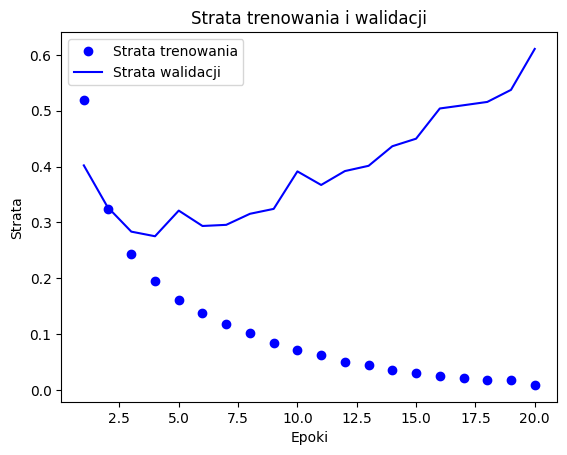

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Parametr bo definiuje linię przerywaną w postaci niebieskich kropek.
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
# Parametr b definiuje ciągłą niebieską linię.
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

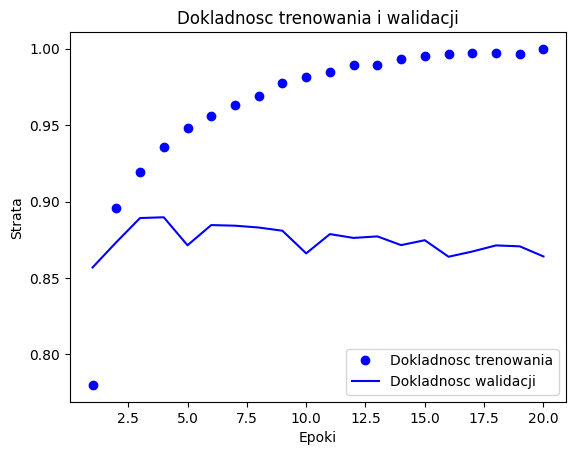

In [ ]:
plt.clf()   # Czyszczenie rysunku.
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

Jak widać, strata trenowania spada z każdą kolejną epoką, a dokładność trenowania wzrasta. Tego oczekujemy od optymalizacji algorytmem spadku gradientu — wartość, którą staramy się minimalizować, powinna maleć w każdej kolejnej iteracji, ale w czwartej epoce strata walidacji i dokładność walidacji rosną. To właśnie przykład sytuacji, przed którą ostrzegałem wcześniej — model sprawdzający się lepiej na treningowym zbiorze danych wcale nie musi sprawdzać się lepiej podczas przetwarzania nowych danych. W praktyce jest to przykład nadmiernego dopasowania — po drugiej epoce model jest zbytnio optymalizowany na treningowym zbiorze danych i uczy się konkretnej reprezentacji treningowego zbioru danych, a nie ogólnej wizji sprawdzającej się również poza treningowym zbiorem danych.

W tym przypadku nadmiernemu dopasowaniu możemy zapobiec, przerywając działanie algorytmu po 3 epokach, ale możemy skorzystać z wielu technik zapobiegających nadmiernemu dopasowaniu modelu.

Przeprowadźmy trenowanie nowej sieci od podstaw (zróbmy to przez cztery epoki), a następnie dokonajmy ewaluacji na podstawie testowego zbioru danych.



In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 25ms/step - loss: 0.4723 - accuracy: 0.8093
Epoch 2/4
49/49 [==============================] - 1s 24ms/step - loss: 0.2807 - accuracy: 0.9001
Epoch 3/4
49/49 [==============================] - 1s 24ms/step - loss: 0.2178 - accuracy: 0.9216
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.2856 - accuracy: 0.8854


In [ ]:
results

[0.2856123745441437, 0.8853600025177002]

To dość naiwne rozwiązanie pozwoliło uzyskać dokładność na poziomie 88%. Dopracowane modele powinny zbliżyć się do 95%.

## Używanie wytrenowanej sieci do generowania przewidywań dotyczących nowych danych

Po wytrenowaniu sieci możemy jej użyć w celu zrobienia czegoś praktycznego. Aby wygenerować wartość określającą prawdopodobieństwo tego, że recenzja jest pozytywna, wystarczy skorzystać z metody predict:

In [ ]:
model.predict(x_test)

782/782 [==============================] - 4s 4ms/step


array([[0.2672613 ],
       [0.99946153],
       [0.80210936],
       ...,
       [0.1262855 ],
       [0.08116628],
       [0.6292975 ]], dtype=float32)

Jak widać, w przypadku nowych próbek sieć jest bardzo pewna swojego werdyktu (generuje wartości zbliżone do 0,99 lub 0,01), ale w przypadku innych generuje o wiele mniej pewne wyniki, takie jak 0,6 lub 0,4.


## Dalsze eksperymenty

Oto eksperymenty, które pomogą Ci utwierdzić się w przekonaniu, że wybraliśmy całkiem sensowną architekturę, z tym że można ją jeszcze usprawnić:

* Korzystaliśmy z dwóch warstw ukrytych. Spróbuj dodać jedną lub trzy warstwy ukryte i sprawdź, jak wpłynie to na dokładność walidacji i testu.
* Spróbuj użyć warstw z większą lub mniejszą liczbą ukrytych jednostek: wypróbuj warstwy z np. 32 i 64 jednostkami.
* Zamiast funkcji straty binary_crossentropy skorzystaj z funkcji straty mse.
* Wypróbuj działanie funkcji aktywacji tanh (funkcja ta była popularna na początku rozwoju sieci neuronowych) — zastąp nią funkcję relu.


## Wnioski


Oto wnioski, które należy wynieść z tego przykładu:

* Zwykle dane wymagają przeprowadzenia wstępnej obróbki, po której można skierować je w formie tensorów do wejścia sieci neuronowej. Sekwencja słów może być przedstawiona w formie wektorów wartości binarnych, ale można to zrobić również na inne sposoby.
* Stosy warstw Dense z aktywacją relu mogą służyć do rozwiązywania różnych problemów (między innymi klasyfikacji tonu wypowiedzi). W związku z tym najprawdopodobniej będziesz często korzystać z nich w przyszłości.
* W przypadku problemu klasyfikacji binarnej (dwie klasy wyjściowe) na końcu sieci powinna znajdować się warstwa Dense z jedną jednostką i funkcją aktywacji sigmoid — wartości wyjściowe generowane przez sieć powinny być skalarami znajdującymi się w zakresie od 0 do 1 (powinny określać prawdopodobieństwo).
* W takiej konfiguracji warstwy wyjściowej sieci funkcją straty powinna być binarna entropia krzyżowa (binary_crossentropy).
* Optymalizator rmsprop jest — ogólnie rzecz biorąc — dobrym wyborem do każdego problemu. W związku z tym masz o jedną rzecz mniej do przeanalizowania.
* Sieci neuronowe wraz z coraz lepszym poznawaniem danych treningowych zaczynają się nadmiernie do nich dopasowywać, co prowadzi do pogorszenia rezultatów przetwarzania nowych danych. Musisz stale monitorować wydajność sieci podczas przetwarzania danych niewchodzących w skład zbioru treningowego.
